In [2]:
%pip install pandas
%pip install scikit-learn
%pip install Pillow
%pip install keras
%pip install matplotlib
%pip install numpy
%pip install opencv-python


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    MobileNet,
    Xception,
    ResNet50V2,
    DenseNet201,
    DenseNet169,
    InceptionV3,
    InceptionResNetV2,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


base_dir = "./aptos2019-blindness-detection"
# Load the datasets
train_df = pd.read_csv(f"{base_dir}/train.csv")
test_df = pd.read_csv(f"{base_dir}/test.csv")


# Preprocessing functions
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        if img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0] == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img


def circle_crop(img, sigmaX=30):
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    return img


def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = crop_image_from_gray(img)
    img = circle_crop(img)
    img = cv2.resize(img, (224, 224))
    return img




KeyboardInterrupt: 

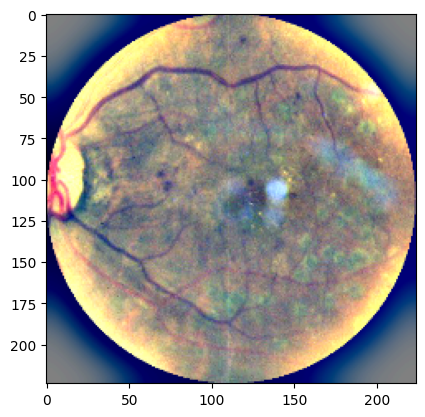

In [ ]:
img=preprocess_image('./0ad36156ad5d.png')
plt.imshow(img)

In [ ]:
# Apply preprocessing to the dataset
train_df["file_path"] = train_df["id_code"].apply(
    lambda x: f"./aptos2019-blindness-detection/train_images/{x}.png"
)
train_df["processed_image"] = train_df["file_path"].apply(preprocess_image)

test_df["file_path"] = test_df["id_code"].apply(
    lambda x: f"./aptos2019-blindness-detection/test_images/{x}.png"
)
test_df["processed_image"] = test_df["file_path"].apply(preprocess_image)

In [ ]:


# Split the training data into train and validation sets
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["diagnosis"]
)

train_df['diagnosis'] = train_df['diagnosis'].astype(str)
val_df['diagnosis'] = val_df['diagnosis'].astype(str)



# Data augmentation
# ImageDataGenerator for training with augmentation and validation without augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Define constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32


# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_df['diagnosis'] = val_df['diagnosis'].astype(str)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 1199 validated image filenames belonging to 5 classes.
Found 300 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [ ]:
EPOCHS = 30

# Define a function to create the model
def create_model(base_model, input_shape=(224, 224, 3)):
    model = Sequential(
        [
            base_model,
            Flatten(),
            Dense(256, activation="relu"),
            Dropout(0.5),
            Dense(5, activation="softmax"),
        ]
    )
    return model

# List of models to train
models = [
    (
        "MobileNet",
        MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "Xception",
        Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "ResNet50V2",
        ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "DenseNet201",
        DenseNet201(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "DenseNet169",
        DenseNet169(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "InceptionV3",
        InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "InceptionResNetV2",
        InceptionResNetV2(
            weights="imagenet", include_top=False, input_shape=(224, 224, 3)
        ),
    ),
]

# Training each model
for model_name, base_model in models:
    model = create_model(base_model)
    model.compile(
        optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    print(f"Training {model_name} model...")

    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_df) // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=len(val_df) // BATCH_SIZE,
        epochs=EPOCHS,
    )

    model.save(f"{model_name}_model.h5")
    
    
    # Evaluate the model
    test_steps = len(test_df) // 32
    test_generator.reset()
    predictions = model.predict(test_generator, steps=test_steps, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average="weighted")
    recall = recall_score(true_classes, predicted_classes, average="weighted")
    f1 = f1_score(true_classes, predicted_classes, average="weighted")

    print(f"{model_name} Model Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    # Classification Report
    print(f"Classification Report for {model_name}:")
    print(
        classification_report(
            true_classes, predicted_classes, target_names=class_labels
        )
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()
    plt.show()

NameError: name 'MobileNet' is not defined

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution